--- Processing LDAP ---
--- Processing MSSQL ---
--- Processing NetBIOS ---
--- Processing Syn ---
--- Processing UDP ---


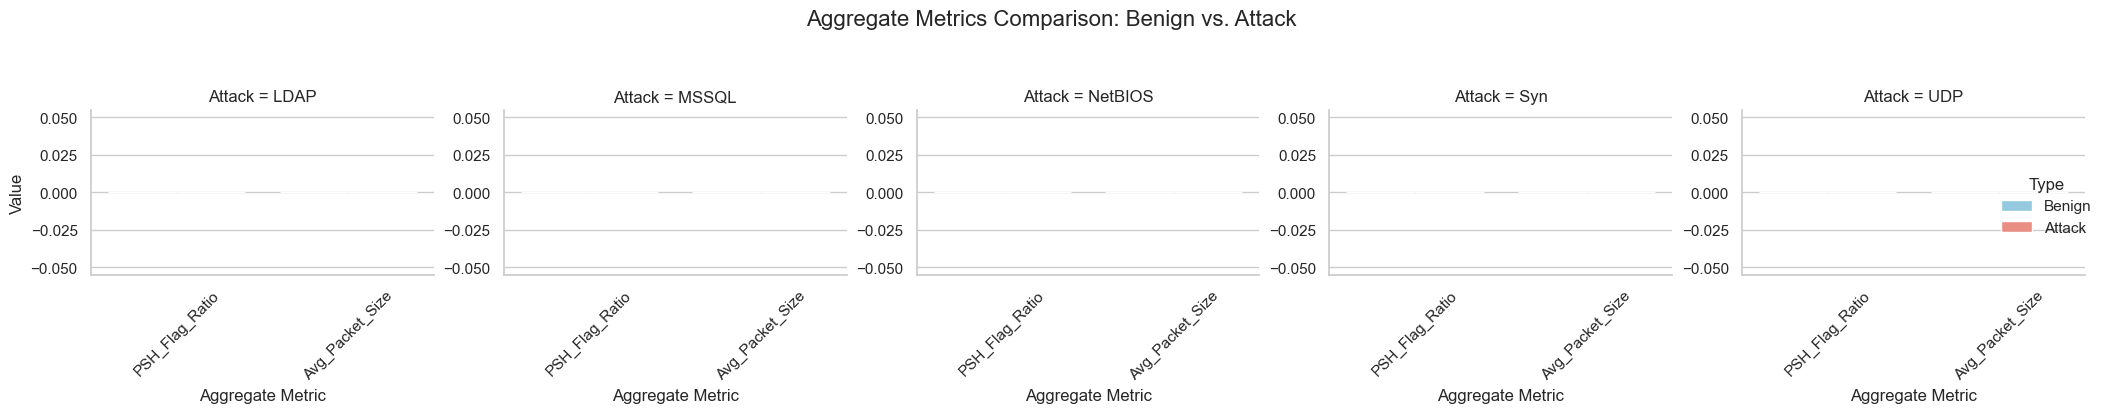

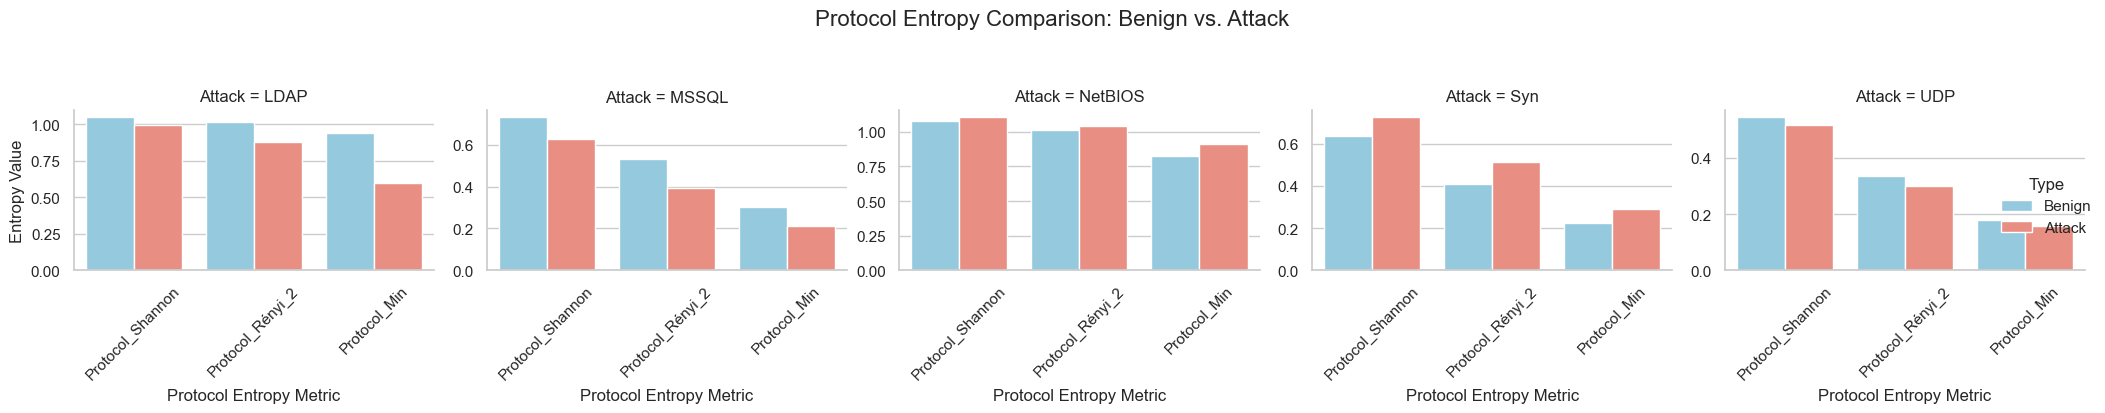

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- 熵計算函數 (不變) ---
def shannon_entropy(p):
    return -np.sum(p * np.log2(p + 1e-12))

def renyi_entropy(p, alpha=2):
    p_normalized = p / p.sum()
    sum_p_alpha = np.sum(p_normalized**alpha)
    return 1/(1-alpha) * np.log2(sum_p_alpha + 1e-12)

def min_entropy(p):
    p_normalized = p / p.sum()
    max_p = np.max(p_normalized)
    return -np.log2(max_p + 1e-12)

def compute_all_entropies(series):
    counts = series.value_counts().values
    if counts.sum() == 0:
        return {"Shannon": 0, "Rényi_2": 0, "Min": 0}
    p = counts / counts.sum()
    return {
        "Shannon": shannon_entropy(p),
        "Rényi_2": renyi_entropy(counts, alpha=2),
        "Min": min_entropy(counts)
    }

# --- 新增：聚合指標計算函數 ---
def compute_aggregate_metrics(df):
    """計算數據幀的聚合統計指標"""
    metrics = {}
    
    # 1. Total Packets (總封包數)
    total_packets = len(df)
    metrics['Total_Packets'] = total_packets
    
    if total_packets == 0:
        metrics['PSH_Flag_Ratio'] = 0
        metrics['Avg_Packet_Size'] = 0
        return metrics

    # 2. PSH Flags Ratio (PSH 旗標比例)
    # 檢查 'PSH Flag Count' 欄位是否存在
    if 'PSH Flag Count' in df.columns:
        # PSH Flag Count > 0 的封包數 / 總封包數
        psh_packets = df[df['PSH Flag Count'] > 0].shape[0]
        metrics['PSH_Flag_Ratio'] = psh_packets / total_packets
    else:
        metrics['PSH_Flag_Ratio'] = 0 # 若無此欄位則為0

    # 3. Average Packet Size (平均封包大小)
    # 我們需要一個代表封包長度的欄位，這裡嘗試幾個常見的名稱
    length_col_candidates = ['Total Length of Fwd Packets', 'Fwd Packet Length Mean', 'Packet Length', 'Length']
    selected_length_col = next((col for col in length_col_candidates if col in df.columns), None)
    
    if selected_length_col:
        total_bytes = df[selected_length_col].sum()
        metrics['Avg_Packet_Size'] = total_bytes / total_packets
    else:
        metrics['Avg_Packet_Size'] = 0 # 若無長度欄位則為0
        
    return metrics

# --- 數據路徑與分析設定 ---
base_path = '/Users/hungwei/Desktop/Proj/AI_DDOS/data/2019'
attack_pairs = {
    'LDAP': ('LDAP-training.parquet', 'LDAP-testing.parquet'),
    'MSSQL': ('MSSQL-training.parquet', 'MSSQL-testing.parquet'),
    'NetBIOS': ('NetBIOS-training.parquet', 'NetBIOS-testing.parquet'),
    'Syn': ('Syn-training.parquet', 'Syn-testing.parquet'),
    'UDP': ('UDP-training.parquet', 'UDP-testing.parquet'),
}

# 更新要讀取的欄位，加入計算所需的新欄位
# !!注意!!: 您需要確認您的Parquet檔案中封包長度和PSH旗標的確切欄位名
columns_to_read = [
    'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol',
    'PSH Flag Count', 'Total Length of Fwd Packets' # 根據您的數據集調整
]

# --- 執行分析 ---
results = []
sample_size = 200000

for attack_name, (train_file, test_file) in attack_pairs.items():
    print(f"--- Processing {attack_name} ---")
    
    # 讀取訓練集 (Benign)
    try:
        df_train_full = pd.read_parquet(os.path.join(base_path, train_file), engine='pyarrow')
        # 確保讀取的欄位存在
        existing_cols_train = [col for col in columns_to_read if col in df_train_full.columns]
        df_train = df_train_full[existing_cols_train].head(sample_size)

        # 計算熵
        for feature in ['Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol']:
             if feature in df_train.columns:
                entropies = compute_all_entropies(df_train[feature])
                for metric_name, value in entropies.items():
                    results.append({'Attack': attack_name, 'Type': 'Benign', 'Category': 'Entropy', 'Metric': f"{feature}_{metric_name}", 'Value': value})
        
        # 計算聚合指標
        agg_metrics = compute_aggregate_metrics(df_train)
        for metric_name, value in agg_metrics.items():
            results.append({'Attack': attack_name, 'Type': 'Benign', 'Category': 'Aggregate', 'Metric': metric_name, 'Value': value})
            
    except Exception as e:
        print(f"Could not process {train_file}: {e}")

    # 讀取測試集 (Attack)
    try:
        df_test_full = pd.read_parquet(os.path.join(base_path, test_file), engine='pyarrow')
        existing_cols_test = [col for col in columns_to_read if col in df_test_full.columns]
        df_test = df_test_full[existing_cols_test].head(sample_size)

        # 計算熵
        for feature in ['Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol']:
             if feature in df_test.columns:
                entropies = compute_all_entropies(df_test[feature])
                for metric_name, value in entropies.items():
                    results.append({'Attack': attack_name, 'Type': 'Attack', 'Category': 'Entropy', 'Metric': f"{feature}_{metric_name}", 'Value': value})
        
        # 計算聚合指標
        agg_metrics = compute_aggregate_metrics(df_test)
        for metric_name, value in agg_metrics.items():
            results.append({'Attack': attack_name, 'Type': 'Attack', 'Category': 'Aggregate', 'Metric': metric_name, 'Value': value})
            
    except Exception as e:
        print(f"Could not process {test_file}: {e}")

results_df = pd.DataFrame(results)

# --- 視覺化 ---
sns.set_theme(style="whitegrid")

# 圖一：聚合指標比較
df_agg = results_df[results_df['Category'] == 'Aggregate']
# 移除 Total_Packets，因為它通常只是樣本大小，尺度差異大
df_agg_plot = df_agg[df_agg['Metric'] != 'Total_Packets']

g_agg = sns.catplot(
    data=df_agg_plot,
    x='Metric', y='Value', hue='Type',
    col='Attack', kind='bar',
    sharey=False, palette={'Benign': 'skyblue', 'Attack': 'salmon'},
    height=4, aspect=1
)
g_agg.fig.suptitle('Aggregate Metrics Comparison: Benign vs. Attack', y=1.03, size=16)
g_agg.set_xticklabels(rotation=45)
g_agg.set_axis_labels("Aggregate Metric", "Value")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# 圖二：熵指標比較 (以 Protocol 為例)
df_entropy_protocol = results_df[results_df['Metric'].str.contains('Protocol')]

g_ent = sns.catplot(
    data=df_entropy_protocol,
    x='Metric', y='Value', hue='Type',
    col='Attack', kind='bar',
    sharey=False, palette={'Benign': 'skyblue', 'Attack': 'salmon'},
    height=4, aspect=1
)
g_ent.fig.suptitle('Protocol Entropy Comparison: Benign vs. Attack', y=1.03, size=16)
g_ent.set_xticklabels(rotation=45)
g_ent.set_axis_labels("Protocol Entropy Metric", "Entropy Value")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

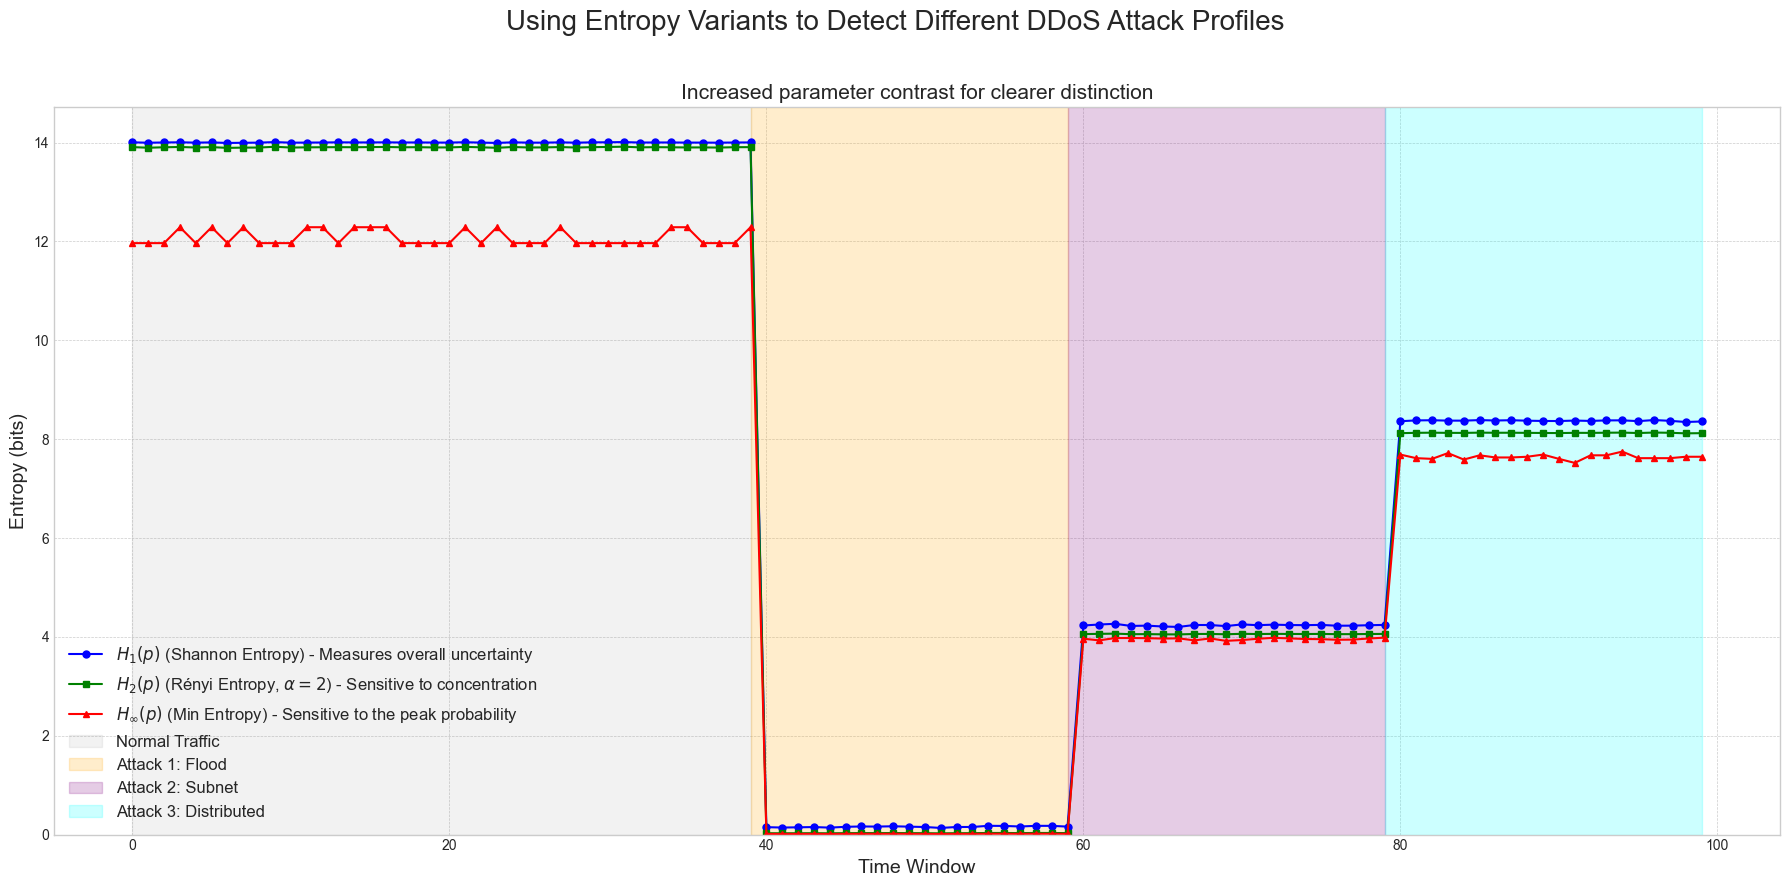

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math

# --- 核心參數設定 (為了突顯效果，我們加大了對比度) ---
class SimulationParams:
    # 網路環境
    IP_POOL_SIZE = 65536  # 模擬一個 /16 網路，讓正常流量更分散
    PACKETS_PER_WINDOW = 20000 # 增加每個時間窗口的封包數，使統計更穩定

    # 時間軸
    T_NORMAL = 40         # 正常流量持續時間
    T_ATTACK = 20         # 每種攻擊的持續時間

    # 攻擊參數
    ATTACK_1_FLOOD = {
        "victim_ip": 1024,
        "intensity": 0.99 # 99% 的流量集中在單一目標
    }
    ATTACK_2_SUBNET = {
        "subnet_start": 2048,
        "subnet_size": 16, # 一個 /28 子網
        "intensity": 0.98 # 98% 的流量集中在子網內
    }
    ATTACK_3_DISTRIBUTED = {
        "target_pool_start": 8192,
        "target_pool_size": 256, # 一個 /24 網段
        "intensity": 0.95 # 95% 的流量集中在一個較大的目標池
    }

# --- 熵計算函數 (與原版相同) ---
def calculate_probabilities(data):
    """將計數數據轉換為概率分佈"""
    if len(data) == 0:
        return np.array([])
    counts = Counter(data)
    total_count = len(data)
    probabilities = np.array([count / total_count for count in counts.values()])
    return probabilities

def shannon_entropy(p):
    """計算 Shannon 熵 (H_1)"""
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def renyi_entropy_alpha2(p):
    """計算 Rényi 熵 (α=2, H_2)"""
    p = p[p > 0]
    return -np.log2(np.sum(p**2))

def min_entropy(p):
    """計算 Min 熵 (H_infinity)"""
    if p.size == 0:
        return 0
    return -np.log2(np.max(p))

# --- 流量模擬函數 (使用強化後的參數) ---
P = SimulationParams

def simulate_normal_traffic(duration):
    """模擬正常流量：目標 IP 在整個 IP 池中均勻分佈"""
    traffic = []
    for _ in range(duration):
        window_traffic = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW)
        traffic.append(window_traffic)
    return traffic

def simulate_attack_1_flood(duration):
    """模擬攻擊 1：單目標洪水攻擊 (UDP Flood)"""
    params = P.ATTACK_1_FLOOD
    traffic = []
    for _ in range(duration):
        is_attack = np.random.rand(P.PACKETS_PER_WINDOW) < params["intensity"]
        attack_traffic = np.full(P.PACKETS_PER_WINDOW, params["victim_ip"])
        background_traffic = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW)
        window_traffic = np.where(is_attack, attack_traffic, background_traffic)
        traffic.append(window_traffic)
    return traffic

def simulate_attack_2_subnet(duration):
    """模擬攻擊 2：子網路攻擊 (Infrastructure Attack)"""
    params = P.ATTACK_2_SUBNET
    traffic = []
    for _ in range(duration):
        is_attack = np.random.rand(P.PACKETS_PER_WINDOW) < params["intensity"]
        attack_traffic = np.random.randint(params["subnet_start"], params["subnet_start"] + params["subnet_size"], size=P.PACKETS_PER_WINDOW)
        background_traffic = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW)
        window_traffic = np.where(is_attack, attack_traffic, background_traffic)
        traffic.append(window_traffic)
    return traffic

def simulate_attack_3_distributed(duration):
    """模擬攻擊 3：分散式攻擊 (Distributed Reflection)"""
    params = P.ATTACK_3_DISTRIBUTED
    traffic = []
    for _ in range(duration):
        is_attack = np.random.rand(P.PACKETS_PER_WINDOW) < params["intensity"]
        attack_traffic = np.random.randint(params["target_pool_start"], params["target_pool_start"] + params["target_pool_size"], size=P.PACKETS_PER_WINDOW)
        background_traffic = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW)
        window_traffic = np.where(is_attack, attack_traffic, background_traffic)
        traffic.append(window_traffic)
    return traffic

# --- 主實驗流程 ---

# 1. 生成流量數據
normal_traffic = simulate_normal_traffic(P.T_NORMAL)
attack1_traffic = simulate_attack_1_flood(P.T_ATTACK)
attack2_traffic = simulate_attack_2_subnet(P.T_ATTACK)
attack3_traffic = simulate_attack_3_distributed(P.T_ATTACK)

total_traffic = normal_traffic + attack1_traffic + attack2_traffic + attack3_traffic
total_duration = len(total_traffic)

# 2. 計算每個時間窗口的熵
h_shannon, h_renyi2, h_min = [], [], []
for window_data in total_traffic:
    probs = calculate_probabilities(window_data)
    h_shannon.append(shannon_entropy(probs))
    h_renyi2.append(renyi_entropy_alpha2(probs))
    h_min.append(min_entropy(probs))

# 3. 可視化結果
time_windows = range(total_duration)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 9))

ax.plot(time_windows, h_shannon, 'o-', label=r'$H_1(p)$ (Shannon Entropy) - Measures overall uncertainty', color='blue', markersize=5)
ax.plot(time_windows, h_renyi2, 's-', label=r'$H_2(p)$ (Rényi Entropy, $\alpha=2$) - Sensitive to concentration', color='green', markersize=5)
ax.plot(time_windows, h_min, '^-', label=r'$H_\infty(p)$ (Min Entropy) - Sensitive to the peak probability', color='red', markersize=5)

# 標記不同階段
ax.axvspan(0, P.T_NORMAL - 1, alpha=0.1, color='gray', label='Normal Traffic')
ax.axvspan(P.T_NORMAL - 1, P.T_NORMAL + P.T_ATTACK - 1, alpha=0.2, color='orange', label='Attack 1: Flood')
ax.axvspan(P.T_NORMAL + P.T_ATTACK - 1, P.T_NORMAL + 2*P.T_ATTACK - 1, alpha=0.2, color='purple', label='Attack 2: Subnet')
ax.axvspan(P.T_NORMAL + 2*P.T_ATTACK - 1, P.T_NORMAL + 3*P.T_ATTACK - 1, alpha=0.2, color='cyan', label='Attack 3: Distributed')

# 設定圖表樣式
fig.suptitle('Using Entropy Variants to Detect Different DDoS Attack Profiles', fontsize=20)
ax.set_title('Increased parameter contrast for clearer distinction', fontsize=15)
ax.set_xlabel('Time Window', fontsize=14)
ax.set_ylabel('Entropy (bits)', fontsize=14)
ax.legend(fontsize=12, loc='lower left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylim(bottom=0) # 熵值不為負
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

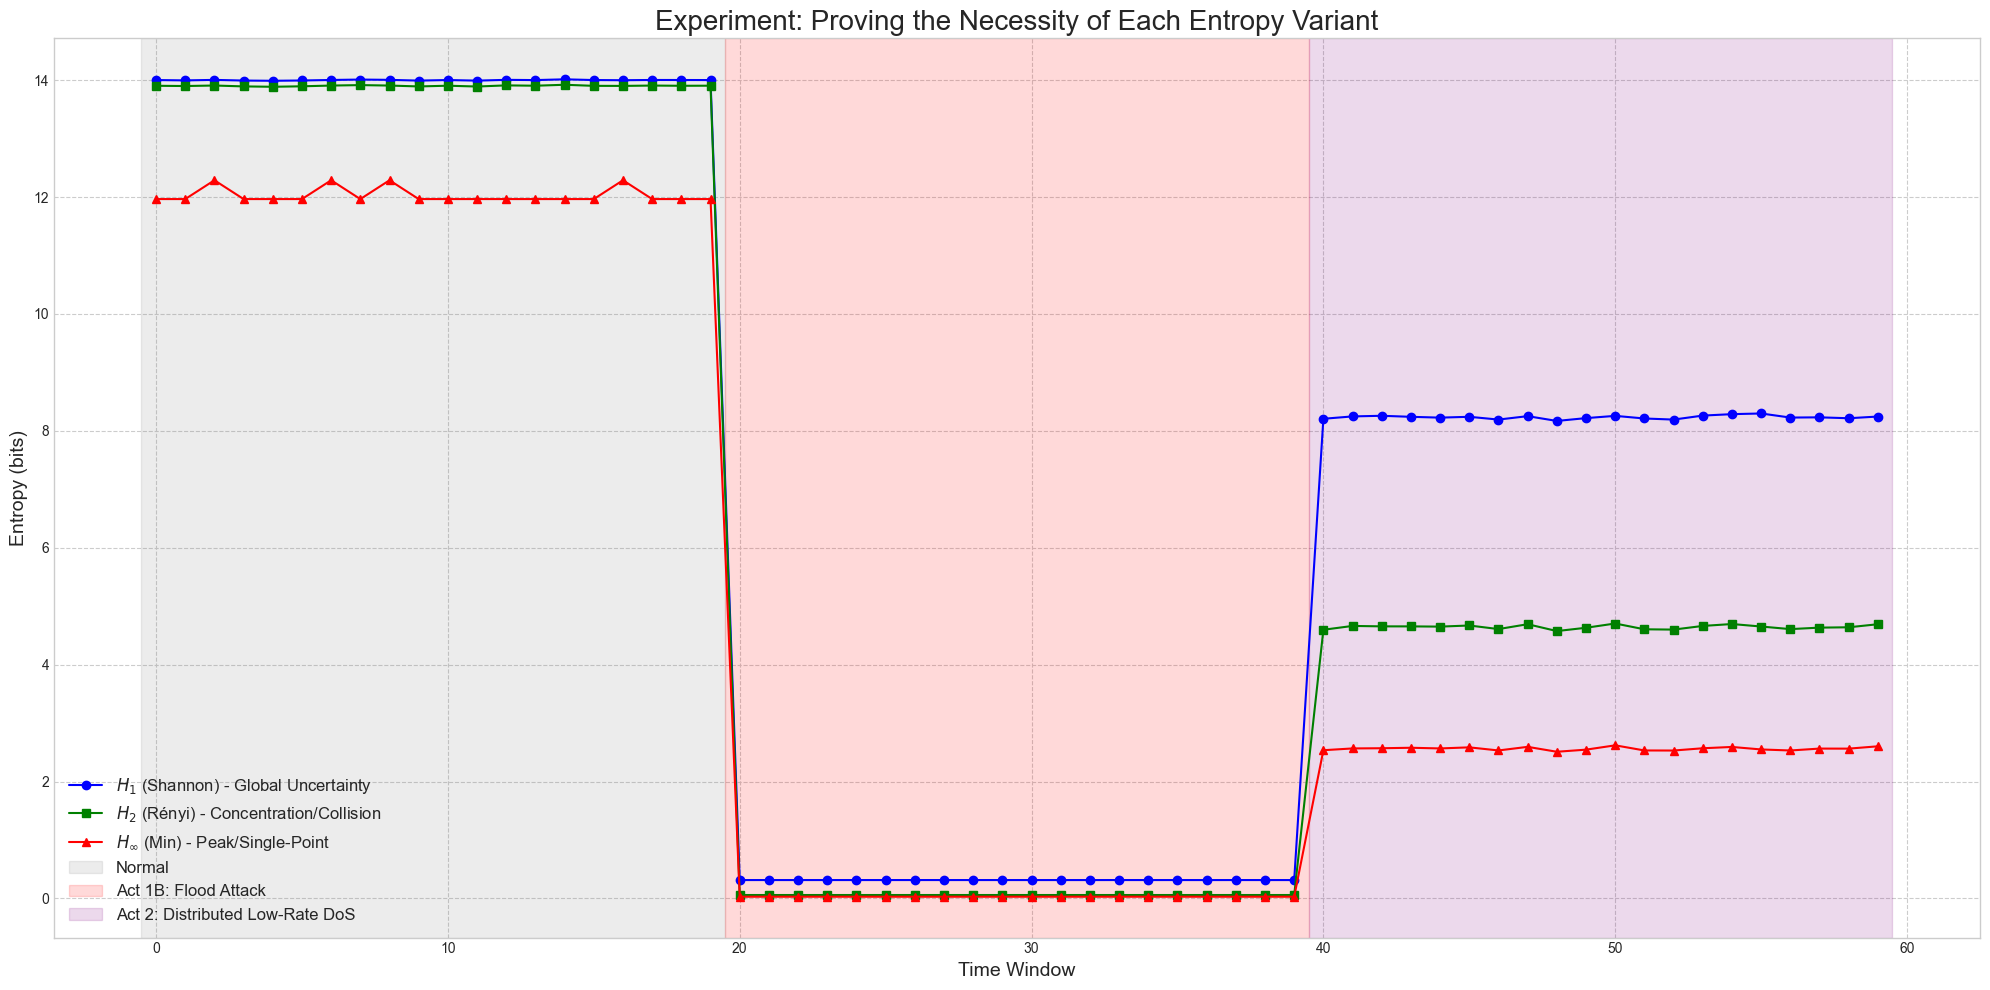

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- 核心參數設定 ---
class SimParams:
    IP_POOL_SIZE = 65536
    PACKETS_PER_WINDOW = 20000
    T_NORMAL = 20
    T_ATTACK = 20

# --- 熵計算函數 (與之前相同) ---
def calculate_probabilities(data):
    counts = Counter(data)
    total_count = len(data)
    return np.array([count / total_count for count in counts.values()])

def shannon_entropy(p):
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def renyi_entropy_alpha2(p):
    p = p[p > 0]
    return -np.log2(np.sum(p**2))

def min_entropy(p):
    if p.size == 0: return 0
    return -np.log2(np.max(p))

# --- 特殊流量模擬函數 ---
P = SimParams

def simulate_normal(duration):
    return [np.random.randint(0, P.IP_POOL_SIZE, P.PACKETS_PER_WINDOW) for _ in range(duration)]

# --- 第一幕： H_infinity 的必要性 ---
def simulate_attack_subnet(duration):
    traffic = []
    for _ in range(duration):
        attack_packets = np.random.randint(1000, 1016, size=int(P.PACKETS_PER_WINDOW * 0.98))
        background_packets = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - len(attack_packets))
        traffic.append(np.concatenate([attack_packets, background_packets]))
    return traffic

def simulate_attack_flood(duration):
    traffic = []
    for _ in range(duration):
        attack_packets = np.full(shape=int(P.PACKETS_PER_WINDOW * 0.98), fill_value=2000)
        background_packets = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - len(attack_packets))
        traffic.append(np.concatenate([attack_packets, background_packets]))
    return traffic

# --- 第二幕： H_1 的必要性 ---
def simulate_subtle_scan(duration):
    """
    攻擊流量雖然分散，但不均勻 (Zipf 分佈)，模擬熱門服務被掃描。
    Zipf 分佈會讓少數 IP 的訪問頻率略高，但又沒有高到能被 H_inf 或 H_2 輕易捕捉。
    """
    traffic = []
    for _ in range(duration):
        # 攻擊目標池為 4096 個 IP，但訪問頻率遵循 Zipf 分佈
        target_pool = np.random.zipf(a=1.2, size=int(P.PACKETS_PER_WINDOW * 0.95)) % 4096 + 3000
        attack_packets = target_pool
        background_packets = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - len(attack_packets))
        traffic.append(np.concatenate([attack_packets, background_packets]))
    return traffic

# --- 第三幕： H_2 的必要性 ---
def simulate_single_outlier(duration):
    """一個 IP 佔 5% 流量，其餘為背景"""
    traffic = []
    main_target_count = int(P.PACKETS_PER_WINDOW * 0.05)
    for _ in range(duration):
        main_attack = np.full(shape=main_target_count, fill_value=4000)
        background = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - main_target_count)
        traffic.append(np.concatenate([main_attack, background]))
    return traffic

def simulate_clustered_attack(duration):
    """一個 IP 佔 5% 流量，另有 20 個 IP 組成小隊各佔 0.5%"""
    traffic = []
    main_target_count = int(P.PACKETS_PER_WINDOW * 0.05)
    cluster_target_count_per_ip = int(P.PACKETS_PER_WINDOW * 0.005)
    total_attack_count = main_target_count + 20 * cluster_target_count_per_ip
    for _ in range(duration):
        main_attack = np.full(shape=main_target_count, fill_value=4000)
        cluster_attack = np.repeat(np.arange(5001, 5021), cluster_target_count_per_ip)
        background = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - total_attack_count)
        traffic.append(np.concatenate([main_attack, cluster_attack, background]))
    return traffic


# --- 主實驗流程 ---


# 1. 生成完整的流量序列
traffic_flow = (
    simulate_normal(P.T_NORMAL) +
    simulate_attack_flood(P.T_ATTACK) +
    simulate_subtle_scan(P.T_ATTACK)
)

total_duration = len(traffic_flow)

# 2. 計算熵值
h_shannon, h_renyi2, h_min = [], [], []


for window_data in traffic_flow:
    probs = calculate_probabilities(window_data)
    h_shannon.append(shannon_entropy(probs))
    h_renyi2.append(renyi_entropy_alpha2(probs))
    h_min.append(min_entropy(probs))

# 3. 可視化結果
time = range(total_duration)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(time, h_shannon, 'o-', label=r'$H_1$ (Shannon) - Global Uncertainty', c='blue')
ax.plot(time, h_renyi2, 's-', label=r'$H_2$ (Rényi) - Concentration/Collision', c='green')
ax.plot(time, h_min, '^-', label=r'$H_\infty$ (Min) - Peak/Single-Point', c='red')

# 標記階段
def mark_span(start, end, color, label):
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.15, label=label)

s = 0
mark_span(s, s + P.T_NORMAL, 'gray', 'Normal')
s += P.T_NORMAL
mark_span(s, s + P.T_ATTACK, 'red', 'Act 1B: Flood Attack')
s += P.T_ATTACK
mark_span(s, s + P.T_ATTACK, 'purple', 'Act 2: Distributed Low-Rate DoS')


# 圖表樣式
ax.set_title('Experiment: Proving the Necessity of Each Entropy Variant', fontsize=20)
ax.set_xlabel('Time Window', fontsize=14)
ax.set_ylabel('Entropy (bits)', fontsize=14)
ax.legend(fontsize=12, loc='lower left')
ax.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

可能 _> 看3 到5個 ->                 

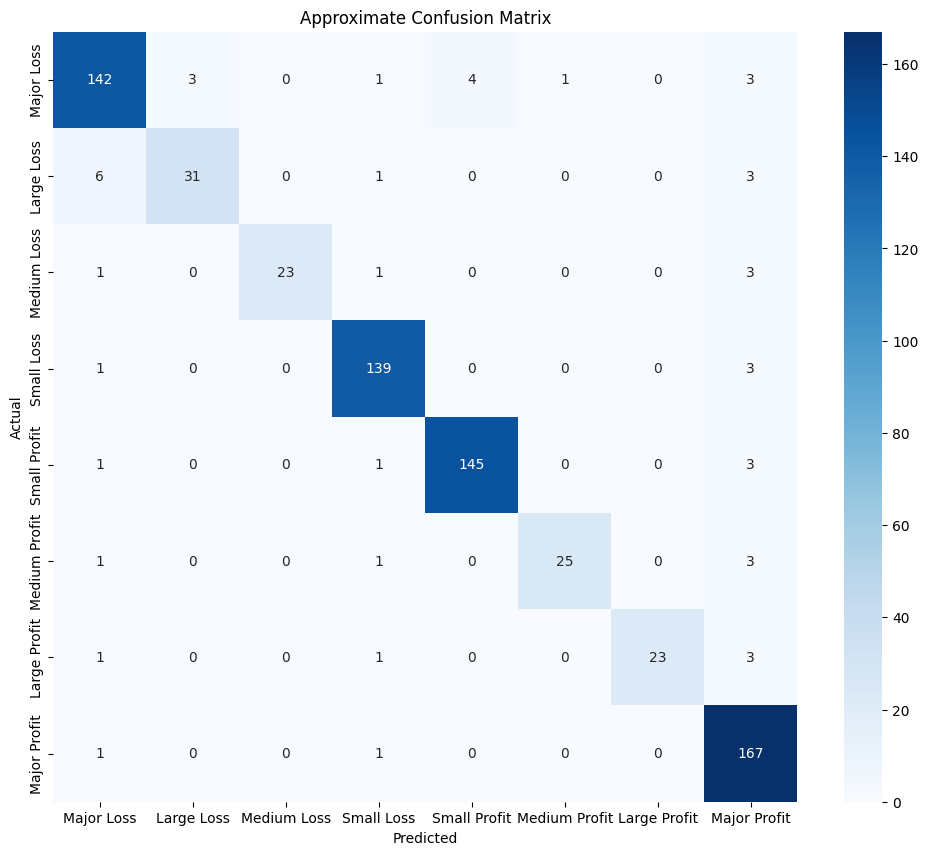

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 類別名稱
classes = ["Major Loss", "Large Loss", "Medium Loss", "Small Loss", 
           "Small Profit", "Medium Profit", "Large Profit", "Major Profit"]

# Support (樣本數)
support = np.array([154, 38, 26, 143, 153, 29, 25, 178])

# Recall
recall = np.array([0.92, 0.82, 0.88, 0.97, 0.95, 0.86, 0.92, 0.94])

# Precision
precision = np.array([0.92, 0.91, 1.00, 0.95, 0.97, 0.96, 1.00, 0.89])

# 計算 TP, FN, FP
TP = np.round(recall * support).astype(int)
FN = support - TP
FP = np.round(TP / precision - TP).astype(int)

# 初始化混淆矩陣
conf_matrix = np.zeros((8,8), dtype=int)

# 將 TP 放到對角線
for i in range(8):
    conf_matrix[i, i] = TP[i]

# 將 FP 隨機分配到其他類別 (這裡簡化)
for i in range(8):
    others = [j for j in range(8) if j != i]
    fp_share = FP[i] // (len(others))
    for j in others:
        conf_matrix[j, i] += fp_share
    remainder = FP[i] - fp_share*len(others)
    if remainder > 0:
        conf_matrix[others[0], i] += remainder

# 畫混淆矩陣
plt.figure(figsize=(12,10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Approximate Confusion Matrix")
plt.show()


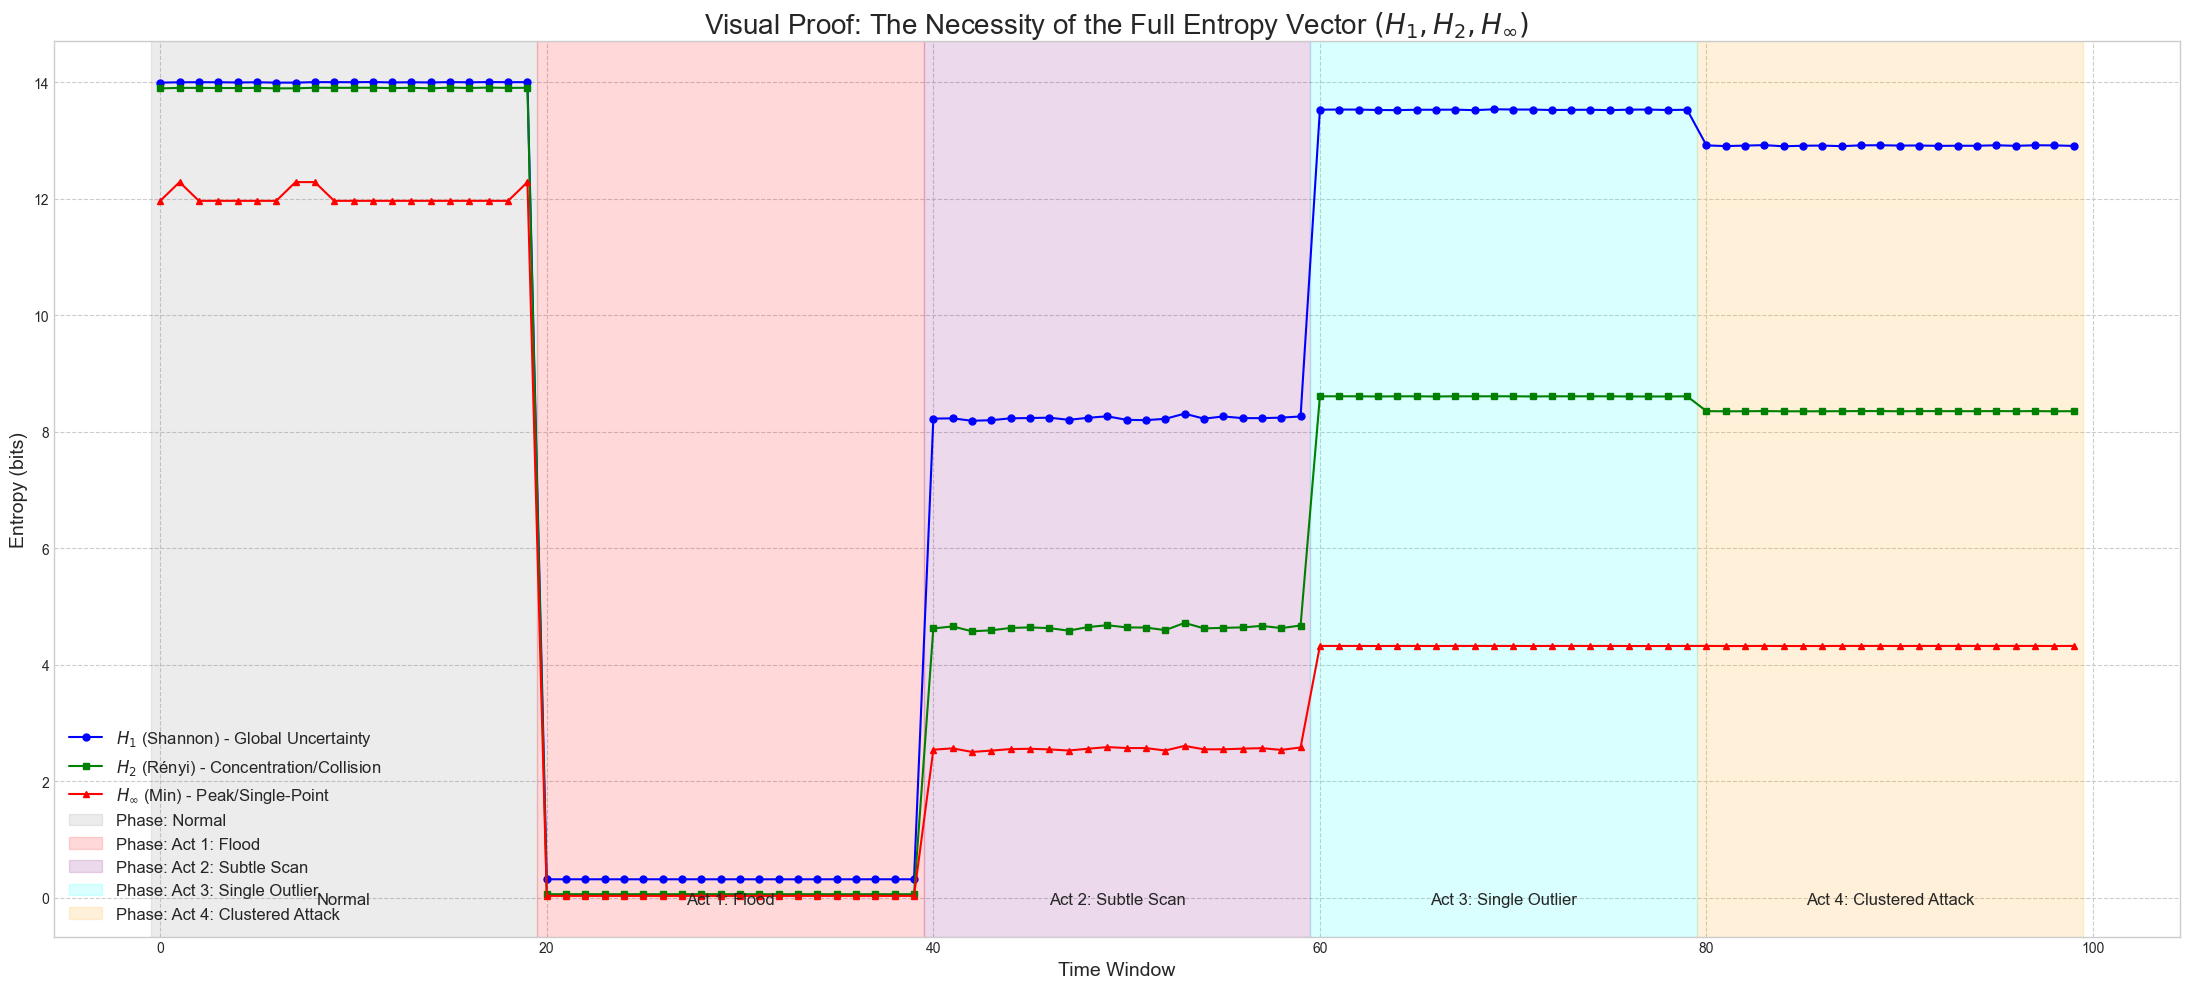


=== 熵分布數值 + 特性總結表 ===
    攻擊類型 Shannon H1 (bits) Rényi H2 (bits) Min H∞ (bits)                             攻擊參數
  Normal             14.00           13.90         12.03                     隨機均勻分布於所有 IP
Flood 攻擊              0.31            0.06          0.03            單一 IP 佔 98% 流量，其餘隨機背景
    隱蔽掃描              8.23            4.63          2.55             Zipf 分布 (95% 來自小子網段)
    單一目標             13.53            8.61          4.32             單一 IP 佔 5% 流量，其餘隨機背景
    集群攻擊             12.91            8.35          4.32 單一 IP 佔 5% 流量，另有 20 個 IP 各佔 0.5%


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- 核心參數設定 ---
class SimParams:
    IP_POOL_SIZE = 65536
    PACKETS_PER_WINDOW = 20000
    T_NORMAL = 20
    T_ATTACK = 20

# --- 熵計算函數 (與之前相同) ---
def calculate_probabilities(data):
    # 確保即使在空數據的情況下也能正常工作
    if not data.any():
        return np.array([])
    counts = Counter(data)
    total_count = len(data)
    return np.array([count / total_count for count in counts.values()])

def shannon_entropy(p):
    p = p[p > 0]
    if p.size == 0: return 0
    return -np.sum(p * np.log2(p))

def renyi_entropy_alpha2(p):
    p = p[p > 0]
    if p.size == 0: return 0
    return -np.log2(np.sum(p**2))

def min_entropy(p):
    if p.size == 0: return 0
    # 處理機率為空的情況
    if not p.any(): return np.log2(SimParams.IP_POOL_SIZE) # 返回理論最大值
    return -np.log2(np.max(p))

# --- 流量模擬函數 ---
P = SimParams

def simulate_normal(duration):
    return [np.random.randint(0, P.IP_POOL_SIZE, P.PACKETS_PER_WINDOW) for _ in range(duration)]

def simulate_attack_flood(duration):
    traffic = []
    for _ in range(duration):
        attack_packets = np.full(shape=int(P.PACKETS_PER_WINDOW * 0.98), fill_value=2000)
        background_packets = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - len(attack_packets))
        traffic.append(np.concatenate([attack_packets, background_packets]))
    return traffic

def simulate_subtle_scan(duration):
    traffic = []
    for _ in range(duration):
        target_pool = np.random.zipf(a=1.2, size=int(P.PACKETS_PER_WINDOW * 0.95)) % 4096 + 3000
        attack_packets = target_pool
        background_packets = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - len(attack_packets))
        traffic.append(np.concatenate([attack_packets, background_packets]))
    return traffic

def simulate_single_outlier(duration):
    """一個 IP 佔 5% 流量，其餘為背景"""
    traffic = []
    main_target_count = int(P.PACKETS_PER_WINDOW * 0.05)
    for _ in range(duration):
        main_attack = np.full(shape=main_target_count, fill_value=4000)
        background = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - main_target_count)
        traffic.append(np.concatenate([main_attack, background]))
    return traffic

def simulate_clustered_attack(duration):
    """一個 IP 佔 5% 流量，另有 20 個 IP 組成小隊各佔 0.5%"""
    traffic = []
    main_target_count = int(P.PACKETS_PER_WINDOW * 0.05)
    cluster_target_count_per_ip = int(P.PACKETS_PER_WINDOW * 0.005)
    num_cluster_ips = 20
    total_attack_count = main_target_count + num_cluster_ips * cluster_target_count_per_ip
    for _ in range(duration):
        main_attack = np.full(shape=main_target_count, fill_value=4000)
        cluster_attack = np.repeat(np.arange(5001, 5001 + num_cluster_ips), cluster_target_count_per_ip)
        background = np.random.randint(0, P.IP_POOL_SIZE, size=P.PACKETS_PER_WINDOW - total_attack_count)
        traffic.append(np.concatenate([main_attack, cluster_attack, background]))
    return traffic

# --- 主實驗流程 ---
# 1. 生成包含五個階段的完整流量序列
traffic_flow = (
    simulate_normal(P.T_NORMAL) +
    simulate_attack_flood(P.T_ATTACK) +
    simulate_subtle_scan(P.T_ATTACK) +
    simulate_single_outlier(P.T_ATTACK) +
    simulate_clustered_attack(P.T_ATTACK)  # <-- 新增的證明階段
)
total_duration = len(traffic_flow)

# 2. 計算熵值
h_shannon, h_renyi2, h_min = [], [], []
for window_data in traffic_flow:
    probs = calculate_probabilities(window_data)
    h_shannon.append(shannon_entropy(probs))
    h_renyi2.append(renyi_entropy_alpha2(probs))
    h_min.append(min_entropy(probs))

# 3. 可視化結果
time = range(total_duration)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(22, 10))

# 繪製三種熵的曲線
ax.plot(time, h_shannon, 'o-', label=r'$H_1$ (Shannon) - Global Uncertainty', c='blue', markersize=5)
ax.plot(time, h_renyi2, 's-', label=r'$H_2$ (Rényi) - Concentration/Collision', c='green', markersize=5)
ax.plot(time, h_min, '^-', label=r'$H_\infty$ (Min) - Peak/Single-Point', c='red', markersize=5)

# 標記五個不同的階段
def mark_span(start, end, color, label):
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.15, label=f'Phase: {label}')
    # 在區域中間添加文字標籤
    ax.text((start + end - 1) / 2, plt.ylim()[0] + 0.5, label, ha='center', va='bottom', fontsize=12, rotation=0)

s = 0
mark_span(s, s + P.T_NORMAL, 'gray', 'Normal')
s += P.T_NORMAL
mark_span(s, s + P.T_ATTACK, 'red', 'Act 1: Flood')
s += P.T_ATTACK
mark_span(s, s + P.T_ATTACK, 'purple', 'Act 2: Subtle Scan')
s += P.T_ATTACK
mark_span(s, s + P.T_ATTACK, 'cyan', 'Act 3: Single Outlier')
s += P.T_ATTACK
mark_span(s, s + P.T_ATTACK, 'orange', 'Act 4: Clustered Attack') # <-- 新增的階段標記

# 圖表樣式
ax.set_title('Visual Proof: The Necessity of the Full Entropy Vector $(H_1, H_2, H_\\infty)$', fontsize=20)
ax.set_xlabel('Time Window', fontsize=14)
ax.set_ylabel('Entropy (bits)', fontsize=14)
ax.legend(fontsize=12, loc='lower left')
ax.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


import pandas as pd

# --- 依照程式模擬階段劃分區間 ---
phases = {
    "Normal": (0, P.T_NORMAL),
    "Flood 攻擊": (P.T_NORMAL, P.T_NORMAL + P.T_ATTACK),
    "隱蔽掃描": (P.T_NORMAL + P.T_ATTACK, P.T_NORMAL + 2*P.T_ATTACK),
    "單一目標": (P.T_NORMAL + 2*P.T_ATTACK, P.T_NORMAL + 3*P.T_ATTACK),
    "集群攻擊": (P.T_NORMAL + 3*P.T_ATTACK, P.T_NORMAL + 4*P.T_ATTACK)
}

# --- 攻擊參數描述 ---
attack_params = {
    "Normal": "隨機均勻分布於所有 IP",
    "Flood 攻擊": "單一 IP 佔 98% 流量，其餘隨機背景",
    "隱蔽掃描": "Zipf 分布 (95% 來自小子網段)",
    "單一目標": "單一 IP 佔 5% 流量，其餘隨機背景",
    "集群攻擊": "單一 IP 佔 5% 流量，另有 20 個 IP 各佔 0.5%"
}

# --- 熵文字描述 (你指定的) ---
entropy_labels = {
    "Normal": ("高", "高", "高"),
    "Flood 攻擊": ("低", "低", "極低"),
    "隱蔽掃描": ("中", "中低", "中高"),
    "單一目標": ("高", "中高", "特定值"),
    "集群攻擊": ("中高", "中", "特定值")
}

# --- 計算每個階段熵的平均值 ---
records = []
for phase, (start, end) in phases.items():
    mean_H1 = np.mean(h_shannon[start:end])
    mean_H2 = np.mean(h_renyi2[start:end])
    mean_Hinf = np.mean(h_min[start:end])
    label_H1, label_H2, label_Hinf = entropy_labels[phase]
    records.append({
        "攻擊類型": phase,
        "Shannon H1 (bits)": f"{mean_H1:.2f}",
        "Rényi H2 (bits)": f"{mean_H2:.2f}",
        "Min H∞ (bits)": f"{mean_Hinf:.2f}",
        "攻擊參數": attack_params[phase]
    })

df_summary = pd.DataFrame(records)

print("\n=== 熵分布數值 + 特性總結表 ===")
print(df_summary.to_string(index=False))


--- Processing LDAP ---
--- Processing MSSQL ---
--- Processing NetBIOS ---
--- Processing Syn ---
--- Processing UDP ---


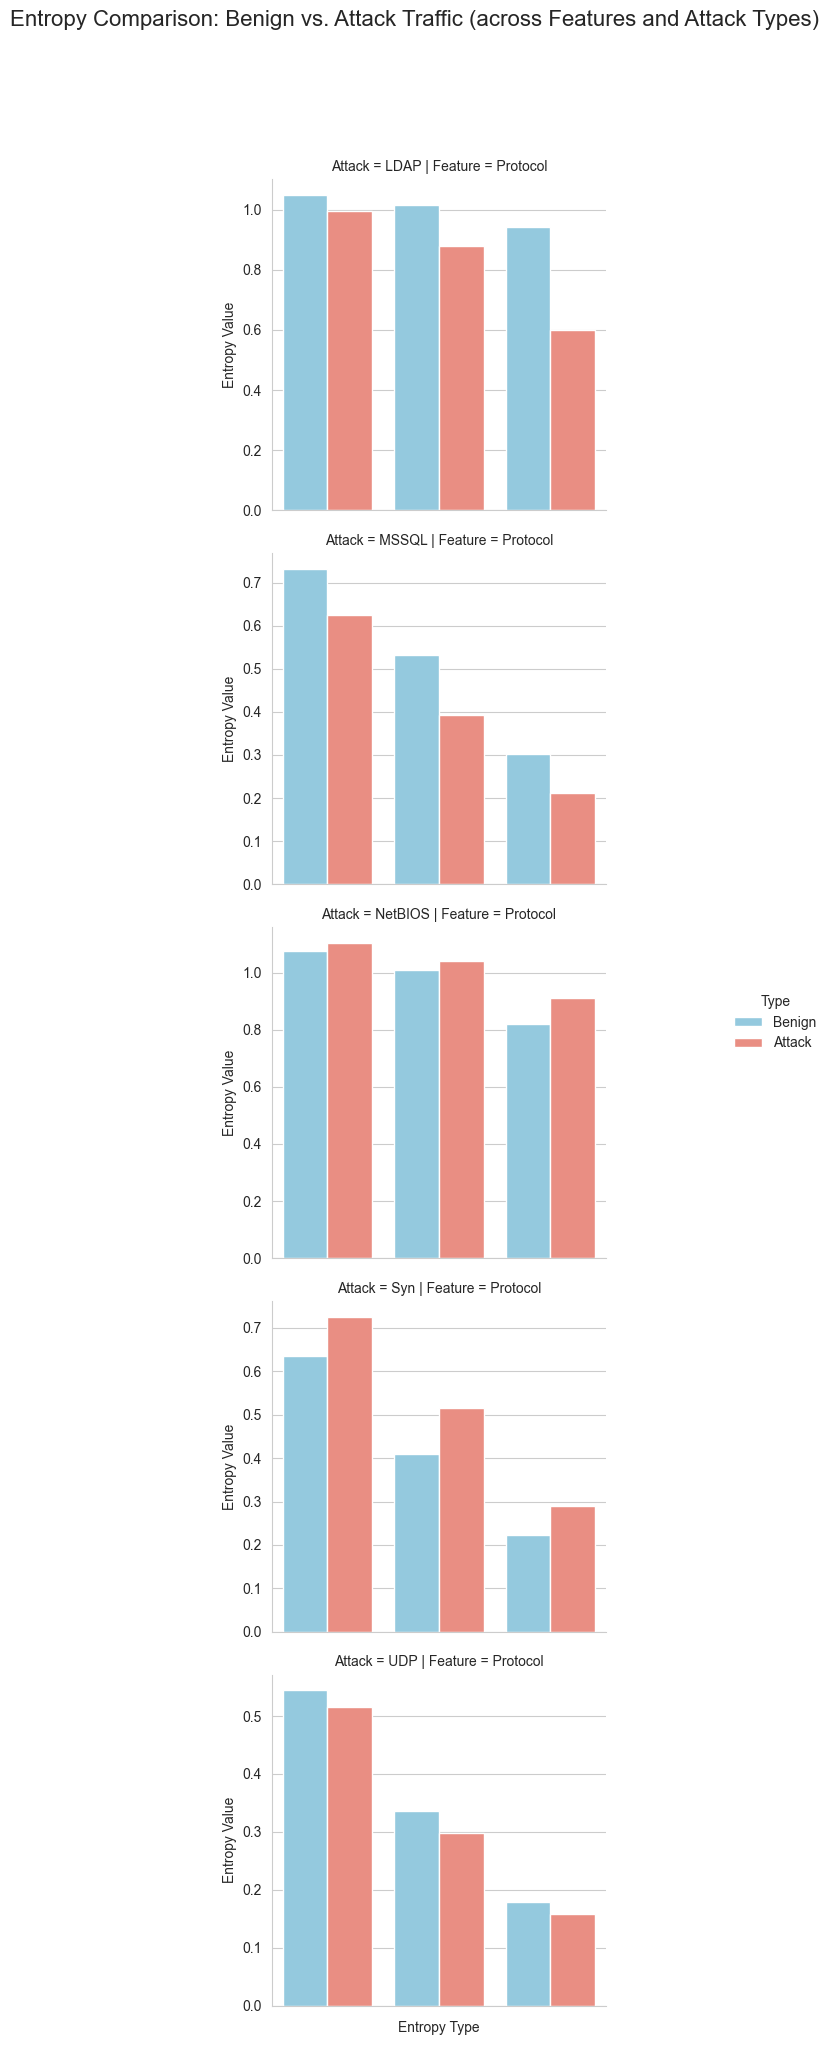

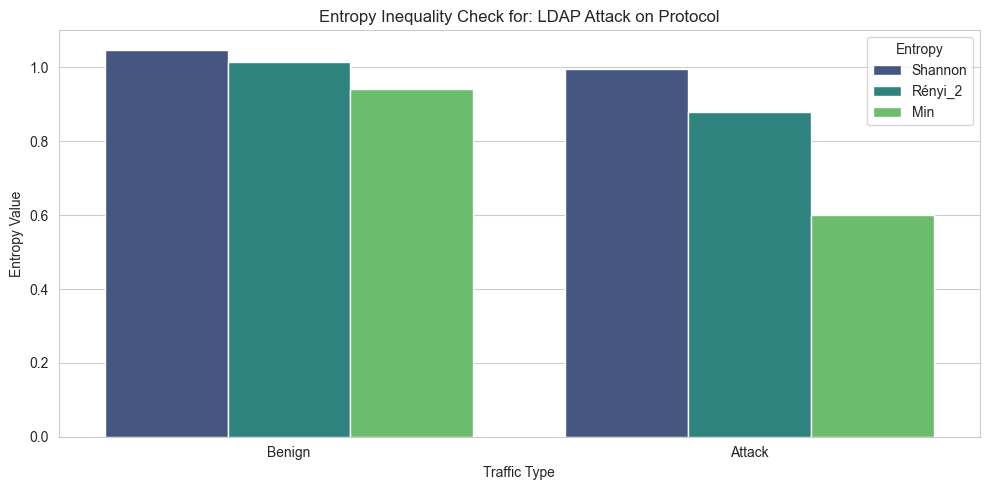

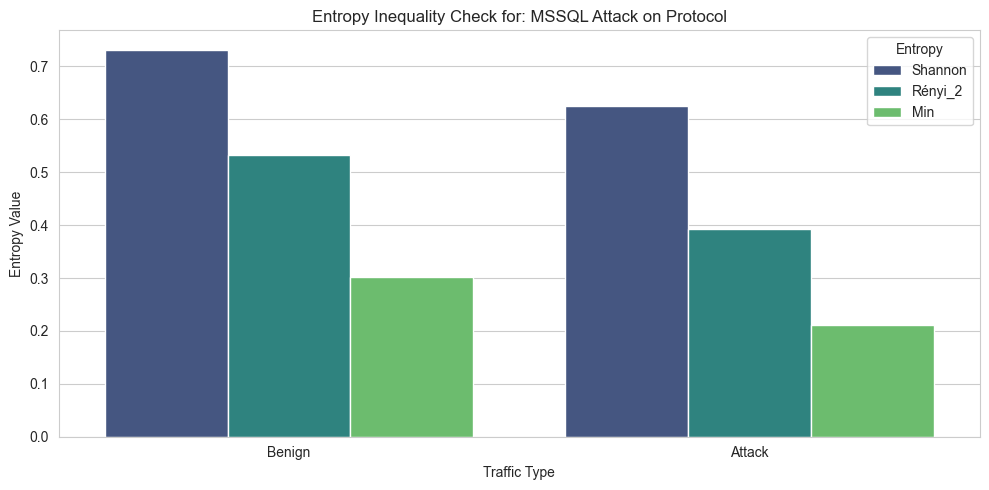

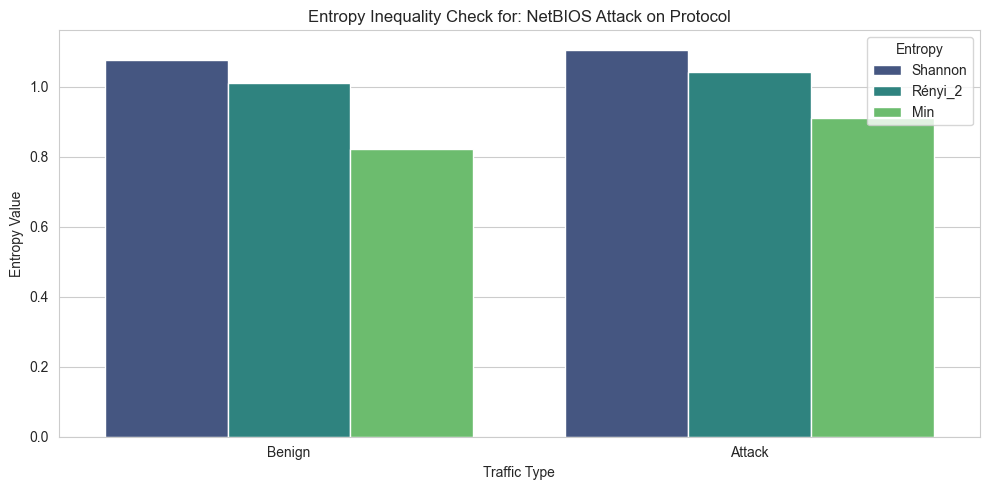

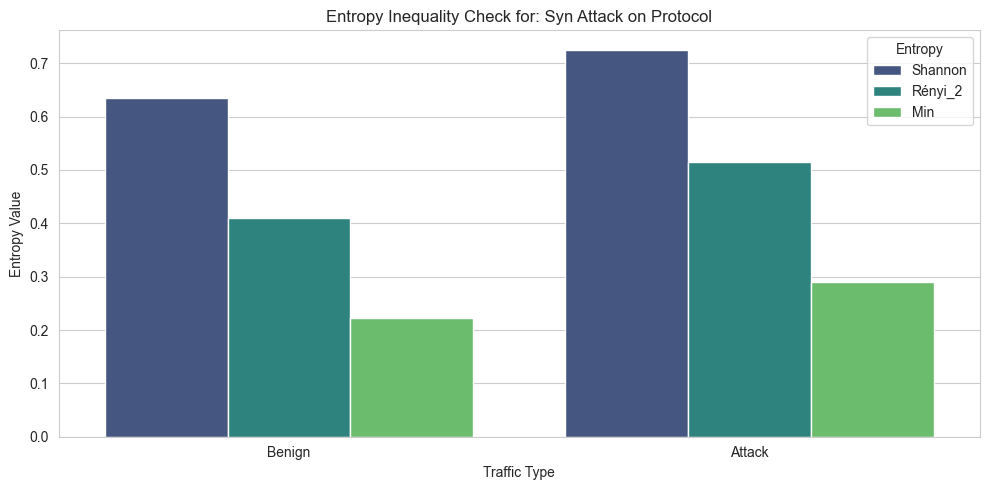

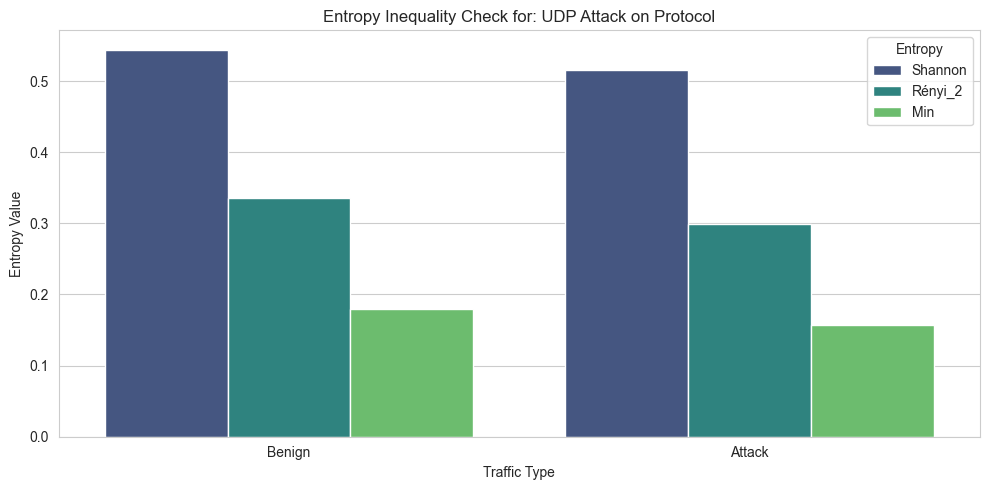

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- 熵計算函數 (與您提供的一致) ---
def shannon_entropy(p):
    return -np.sum(p * np.log2(p + 1e-12))

def renyi_entropy(p, alpha=2):
    # 確保 p 的和為 1
    p_normalized = p / p.sum()
    sum_p_alpha = np.sum(p_normalized**alpha)
    # 加上 epsilon 以避免 log(0)
    return 1/(1-alpha) * np.log2(sum_p_alpha + 1e-12)

def min_entropy(p):
    # 確保 p 的和為 1
    p_normalized = p / p.sum()
    max_p = np.max(p_normalized)
    # 加上 epsilon 以避免 log(0)
    return -np.log2(max_p + 1e-12)

def compute_all_entropies(series):
    """計算一個 Pandas Series 的三種熵"""
    counts = series.value_counts().values
    if counts.sum() == 0:
        return {"Shannon": 0, "Rényi_2": 0, "Min": 0}
        
    p = counts / counts.sum()
    
    return {
        "Shannon": shannon_entropy(p),
        "Rényi_2": renyi_entropy(counts, alpha=2), # 傳入 counts 讓函數內部標準化
        "Min": min_entropy(counts) # 傳入 counts 讓函數內部標準化
    }

# --- 數據路徑與分析設定 ---
base_path = '/Users/hungwei/Desktop/Proj/AI_DDOS/data/2019'
# 我們選擇幾個有代表性的攻擊類型進行比較
attack_pairs = {
    'LDAP': ('LDAP-training.parquet', 'LDAP-testing.parquet'),
    'MSSQL': ('MSSQL-training.parquet', 'MSSQL-testing.parquet'),
    'NetBIOS': ('NetBIOS-training.parquet', 'NetBIOS-testing.parquet'),
    'Syn': ('Syn-training.parquet', 'Syn-testing.parquet'),
    'UDP': ('UDP-training.parquet', 'UDP-testing.parquet'),
}

# 我們關心的特徵欄位
features_to_analyze = ['Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol']

# --- 執行分析 ---
results = []
sample_size = 200000 # 讀取樣本數量，避免記憶體耗盡

for attack_name, (train_file, test_file) in attack_pairs.items():
    print(f"--- Processing {attack_name} ---")
    
    # 讀取訓練集 (正常流量)
    try:
        df_train = pd.read_parquet(os.path.join(base_path, train_file), engine='pyarrow').head(sample_size)
        for feature in features_to_analyze:
            if feature in df_train.columns:
                entropies = compute_all_entropies(df_train[feature])
                for entropy_name, value in entropies.items():
                    results.append({'Attack': attack_name, 'Type': 'Benign', 'Feature': feature, 'Entropy': entropy_name, 'Value': value})
    except Exception as e:
        print(f"Could not process {train_file}: {e}")

    # 讀取測試集 (攻擊流量)
    try:
        df_test = pd.read_parquet(os.path.join(base_path, test_file), engine='pyarrow').head(sample_size)
        for feature in features_to_analyze:
             if feature in df_test.columns:
                entropies = compute_all_entropies(df_test[feature])
                for entropy_name, value in entropies.items():
                    results.append({'Attack': attack_name, 'Type': 'Attack', 'Feature': feature, 'Entropy': entropy_name, 'Value': value})
    except Exception as e:
        print(f"Could not process {test_file}: {e}")

results_df = pd.DataFrame(results)

# --- 視覺化 ---
sns.set_style("whitegrid")
g = sns.catplot(
    data=results_df, 
    x='Entropy', 
    y='Value', 
    hue='Type', 
    col='Feature', 
    row='Attack',
    kind='bar',
    sharey=False, # 每個子圖的 Y 軸獨立
    palette={'Benign': 'skyblue', 'Attack': 'salmon'},
    height=4,
    aspect=0.8
)
g.fig.suptitle('Entropy Comparison: Benign vs. Attack Traffic (across Features and Attack Types)', y=1.02, size=16)
g.set_xticklabels(rotation=45)
g.set_axis_labels("Entropy Type", "Entropy Value")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 視覺化不等式關係
for attack_name in attack_pairs.keys():
    for feature in features_to_analyze:
        subset = results_df[(results_df['Attack'] == attack_name) & (results_df['Feature'] == feature)]
        if not subset.empty:
            plt.figure(figsize=(10, 5))
            sns.barplot(data=subset, x='Type', y='Value', hue='Entropy', palette='viridis')
            plt.title(f'Entropy Inequality Check for: {attack_name} Attack on {feature}')
            plt.ylabel('Entropy Value')
            plt.xlabel('Traffic Type')
            plt.tight_layout()
            plt.show()

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 先假設這些事先都做好了：
#    df: 原始 DataFrame，裡面有 existing_features、Label 兩個欄位
#    existing_features: list of 特徵欄位名稱
#    Label 裡的值只有 "DDoS" 或 "Benign"
# ------------------------------------------------------------

# 1. 取樣 (如果要加速可以只用 30% 資料，或把這段刪掉改成全資料)
df_sampled = df.sample(frac=0.3, random_state=42).reset_index(drop=True)
X = df_sampled[existing_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)           # 標準化後的特徵矩陣
y_true = df_sampled["Label"].values           # 真實標籤（"DDoS" / "Benign"）
N = len(y_true)                              # 樣本數 (30% 之後的樣本總數)

# 2. PSO Reward Function 裡要用到的常數：
w_ddos = 0.7           # 欲「鼓勵」抓到 DDoS 的權重 (越大越想召回高)
w_benign = 0.3         # 欲「懲罰」誤抓正常的權重 (越大越在意誤判)
theta = 0.99           # 純度門檻：至少要 99% 以上純 DDoS 才算合格
lambda_penalty = 1.0   # 若任何群都沒達到純度，就給這個懲罰 (通常設定 > 0)

K = 2                  # GMM 分成 2 群：1 群大多 DDoS，1 群大多 Benign

D_reduced = X_scaled.shape[1]  # 維度（標準化後的特徵數）

# ------------------------------------------------------------
# 3. 定義「單顆粒」的評分函數 evaluate_single_particle()
#    輸入 means_flat：shape=(K*D_reduced,), 代表 K 個高斯中心展平成一維向量
#    回傳一個實數，就是 F(w)（要被 PSO 最小化）
# ------------------------------------------------------------
def evaluate_single_particle(means_flat):
    """
    输入:
      - means_flat: 长度 = K * D_reduced 的一维 numpy array，
        代表 K 个高斯中心展平成一块。
    输出:
      - 该粒子的 loss 分数，越小越好。
    """
    # 1. 把一维向量还原成 (K, D_reduced)
    means = means_flat.reshape(K, D_reduced)

    # 2. 用这些 means_init 建立一个 GMM，先跑 5 轮 EM
    gmm = GaussianMixture(
        n_components=K,
        covariance_type="diag",
        max_iter=5,
        tol=1e-3,
        init_params="random",
        random_state=42
    )
    try:
        gmm.means_init = means.copy()
        gmm.weights_init = np.ones(K) / K
        gmm.fit(X_scaled)
    except Exception:
        # 如果 GMM 因协方差奇异或收敛失败，就直接给惩罚
        return lambda_penalty * 10

    # 3. 拿训练好的 GMM 把 X_scaled 分配到 K 个 cluster
    labels = gmm.predict(X_scaled)

    # 4. 检查「空群／极小群」：如果某个 cluster size < min_cluster_size，直接重惩
    min_cluster_size = int(0.05 * N)  # 举例：群里至少要有 5% 的样本才算合法
    for k in range(K):
        size_k = np.sum(labels == k)
        if size_k < min_cluster_size:
            return lambda_penalty * 10

    # 5. 计算每个群的 d_k、b_k、纯度 purity_k，收集所有纯度 >= θ 的群的 reward
    fitness_list = []
    cluster_ok = False
    for k in range(K):
        idx_k = (labels == k)
        d_k = np.sum(y_true[idx_k] == "DDoS")
        b_k = np.sum(y_true[idx_k] == "Benign")
        total_k = d_k + b_k

        # 防止除以 0，但前面 min_cluster_size 已确保 total_k >= 1
        if total_k == 0:
            # 理论上不会到这一步，仍放个兜底
            return lambda_penalty * 10

        purity_k = d_k / total_k
        if purity_k >= theta:
            cluster_ok = True
            # 正式 reward 公式：- w_ddos * (d_k / N)  +  w_benign * (b_k / total_k)
            term = - w_ddos * (d_k / N) + w_benign * (b_k / total_k)
            fitness_list.append(term)

    # 6. 如果至少有一个群达标，取所有满足纯度门槛群的最小值
    if cluster_ok and len(fitness_list) > 0:
        return min(fitness_list)
    else:
        # 7. 没有任何群达纯度门槛，就做「部分惩罚」：
        #    先找出这 K 个群里谁的纯度是最高（best_purity），
        #    然后 loss = λ_penalty + (theta - best_purity)，
        #    让 PSO 能看到哪个解的群纯度已经比较接近 θ。
        best_purity = 0.0
        for k in range(K):
            idx_k = (labels == k)
            d_k = np.sum(y_true[idx_k] == "DDoS")
            b_k = np.sum(y_true[idx_k] == "Benign")
            total_k = d_k + b_k if (d_k + b_k) > 0 else 1
            purity_k = d_k / total_k
            if purity_k > best_purity:
                best_purity = purity_k

        # 部分惩罚：惩罚值 = λ_penalty + (θ - best_purity)
        # θ - best_purity 越小（越接近纯度门槛），loss 越接近 λ_penalty，PSO 可区分方向。
        penalty_term = lambda_penalty + (theta - best_purity)
        return penalty_term



# ------------------------------------------------------------
# 4. 把「單顆粒評分」包成 PSO 能用的 objective 函數
#    pyswarms 要求：
#      input:  shape = (n_particles, dimensions)
#      output: shape = (n_particles,)
# ------------------------------------------------------------
def pso_objective(particles_array):
    # particles_array[i] 就是第 i 顆粒的 means_flat (長度 = K*D_reduced)
    scores = []
    for p in particles_array:
        score = evaluate_single_particle(p)
        scores.append(score)
    return np.array(scores)


# ------------------------------------------------------------
# 5. PSO 初始化
# ------------------------------------------------------------

dimension = K * D_reduced
options = {
    'c1': 1.5,   # 個體學習因子
    'c2': 1.5,   # 社會學習因子
    'w': 0.8,    # 慣性權重
    'k': 30,     # gbest 時可設定為與 n_particles 相同
    'p': 2       # Minkowski 距離 (常設 2)
}
n_particles = 30

optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles,
    dimensions=dimension,
    options=options
)

# ------------------------------------------------------------
# 6. 執行 PSO 最小化 pso_objective，迭代 30 次
# ------------------------------------------------------------
best_cost, best_pos = optimizer.optimize(pso_objective, iters=30, verbose=True)
print(f"\nPSO 優化完成，最優 loss: {best_cost:.6f}")


# ------------------------------------------------------------
# 7. 用找到的最佳 means 做最終 GMM 訓練 (iter=100，tol=1e-4)
# ------------------------------------------------------------
best_means = best_pos.reshape(K, D_reduced)
gmm_final = GaussianMixture(
    n_components=K,
    covariance_type="diag",
    max_iter=100,
    tol=1e-4,
    random_state=42
)
gmm_final.means_init = best_means.copy()
gmm_final.weights_init = np.ones(K) / K
gmm_final.fit(X_scaled)

# 8. 最後把所有樣本分群，並計算各群純度
labels_final = gmm_final.predict(X_scaled)
df_sampled["PredictedCluster"] = labels_final

for k in range(K):
    idx_k = (labels_final == k)
    d_k = np.sum(y_true[idx_k] == "DDoS")
    b_k = np.sum(y_true[idx_k] == "Benign")
    total_k = d_k + b_k if (d_k + b_k) > 0 else 1
    purity = d_k / total_k
    print(f"Cluster {k}: DDoS={d_k}, Benign={b_k}, 純度={purity:.4f}")


2025-06-01 17:07:26,699 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.8, 'k': 30, 'p': 2}
pyswarms.single.global_best:   0%|          |0/30/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  w


PSO 優化完成，最優 loss: 1.081806
Cluster 0: DDoS=0, Benign=0, 純度=0.0000
Cluster 1: DDoS=12976, Benign=3625, 純度=0.7816


In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pyswarms as ps

# ------------------------------------------------------------
# Assumptions (as per your original code):
# df: DataFrame with existing_features and 'Label' ("DDoS" or "Benign")
# existing_features: list of feature column names
# ------------------------------------------------------------

# Create dummy df and existing_features for runnable example
np.random.seed(42)
n_samples_total = 1000
n_features = 5
existing_features = [f'feature_{j}' for j in range(n_features)]
data = np.random.rand(n_samples_total, n_features)
labels = np.random.choice(["Benign", "DDoS"], size=n_samples_total, p=[0.7, 0.3])
df = pd.DataFrame(data, columns=existing_features)
df["Label"] = labels

# 1. 隨機抽樣並標準化 (Random sampling and standardization)
df_sampled = df.sample(frac=0.8, random_state=42).reset_index(drop=True)

X = df_sampled[existing_features].copy()
y_true = df_sampled["Label"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 用 GMM 分群 (n_components=2) (GMM clustering)
gmm = GaussianMixture(n_components=2, random_state=42, n_init=10) # Added n_init for stability
gmm.fit(X_scaled)
y_cluster = gmm.predict(X_scaled)
df_sampled["GMM_Cluster"] = y_cluster
df_sampled["True_Label"] = y_true

# 3. 計算每個 cluster 的 d_k (DDoS 筆數) 與 b_k (Benign 筆數)
#    (Calculate d_k (DDoS count) and b_k (Benign count) for each cluster)
label_map = {"Benign": 0, "DDoS": 1}
df_sampled["Label_bin"] = df_sampled["True_Label"].map(label_map)

cluster_stats_list = [] # Renamed to avoid conflict with a potential variable
for k_cluster_id in sorted(df_sampled["GMM_Cluster"].unique()):
    sub = df_sampled[df_sampled["GMM_Cluster"] == k_cluster_id]
    d_k = int((sub["Label_bin"] == 1).sum())
    b_k = int((sub["Label_bin"] == 0).sum())
    cluster_stats_list.append((d_k, b_k))

# 總樣本數 N (Total sample count N)
N = df_sampled.shape[0]
total_ddos_samples = df_sampled["Label_bin"].sum() # Total DDoS samples

# 4. 定義 PSO 的目標函數 (Define PSO objective function)
# This objective function now uses the particle's weights directly.

def pso_objective_optimized(particles):
    n_particles = particles.shape[0]
    costs = np.zeros(n_particles)

    theta_high_purity = 0.9  # High-purity threshold (fixed as per original logic)

    for i in range(n_particles):
        weight_recall, weight_fpr = particles[i] # These are the dynamic weights from PSO

        ddos_detected_in_high_purity = 0
        benign_misclassified_in_high_purity = 0
        total_samples_in_high_purity_clusters = 0

        for (d_k, b_k) in cluster_stats_list:
            total_k_samples = d_k + b_k
            if total_k_samples == 0:
                purity_k = 0
            else:
                purity_k = d_k / total_k_samples

            if purity_k >= theta_high_purity:
                ddos_detected_in_high_purity += d_k
                benign_misclassified_in_high_purity += b_k
                total_samples_in_high_purity_clusters += total_k_samples

        if total_ddos_samples == 0: # Should not happen if there are DDoS samples
             costs[i] = 1e9 # Penalize heavily if no DDoS samples exist in the dataset
             continue

        if ddos_detected_in_high_purity == 0 :
             # If no DDoS detected in high-purity clusters (perhaps due to GMM or low data)
             # or if the high-purity clusters themselves are empty
             recall = 0
        else:
            recall = ddos_detected_in_high_purity / total_ddos_samples

        if total_samples_in_high_purity_clusters > 0:
            fpr = benign_misclassified_in_high_purity / total_samples_in_high_purity_clusters
        elif benign_misclassified_in_high_purity > 0: # Benign misclassified but no total samples (edge case)
            fpr = 1.0 # Max penalty
        else: # No benign misclassified in (empty or pure) high purity clusters
            fpr = 0.0

        # Objective: Maximize (weight_recall * recall - weight_fpr * fpr)
        # PSO minimizes, so we take the negative
        F_objective = weight_recall * recall - weight_fpr * fpr
        costs[i] = -F_objective

    return costs


# 5. 用 pyswarms 執行 PSO (Execute PSO using pyswarms)
dimensions = 2
# Define bounds for the weights:
# particles[i][0] = weight_recall,  e.g., [0.5, 1.5]
# particles[i][1] = weight_fpr,     e.g., [0.1, 5.0]
# These bounds are crucial and might need tuning based on expected behavior.
# If weight_recall can be 0, then recall might be ignored.
# If weight_fpr can be 0, then FPR might be ignored.
# Let's ensure they are positive and have a reasonable range.
bounds = (
    np.array([0.5, 0.1]),  # Lower bounds for [weight_recall, weight_fpr]
    np.array([1.5, 5.0])   # Upper bounds for [weight_recall, weight_fpr]
)


options = {
    "c1": 1.5,
    "c2": 1.5,
    "w": 0.5
}

max_iter = 100 # Keep iterations reasonable for example, increase for real tasks
n_particles_pso = 50 # Reduced for faster example, increase for real tasks

optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles_pso,
    dimensions=dimensions,
    options=options,
    bounds=bounds
)

# Start optimization
best_cost_optimized, best_pos_optimized = optimizer.optimize(pso_objective_optimized, iters=max_iter)

w_recall_opt, w_fpr_opt = best_pos_optimized

print("--- Optimized PSO with Dynamic Weights for Objective Function ---")
print(f"最佳權重 (Optimized Weights): w_recall (for Recall) = {w_recall_opt:.4f}, w_fpr (for FPR) = {w_fpr_opt:.4f}")
# The best_cost_optimized is -F. So F = -best_cost_optimized
print(f"對應的目標函數最大值 F = {-best_cost_optimized:.6f}")

# Recalculate and print statistics using the original fixed theta for cluster selection
# The PSO did not change theta, it changed how recall and FPR are weighted.
print("\n分群統計資訊 (固定純度門檻 theta=0.9):")
print("(Cluster Statistics based on fixed purity threshold theta=0.9):")
print("Cluster\tTotal\tDDoS\tBenign\tPurity(DDoS%)\tBenign(%)")

ddos_final_hp = 0
benign_final_hp = 0
total_final_hp = 0
theta_fixed = 0.9

for k_idx, (d_k_val, b_k_val) in enumerate(cluster_stats_list):
    total_k_val = d_k_val + b_k_val
    purity_val = d_k_val / total_k_val if total_k_val > 0 else 0
    benign_ratio_val = b_k_val / total_k_val if total_k_val > 0 else 0
    print(f"{k_idx}\t{total_k_val}\t{d_k_val}\t{b_k_val}\t{purity_val:.2%}\t\t{benign_ratio_val:.2%}")
    if purity_val >= theta_fixed:
        ddos_final_hp += d_k_val
        benign_final_hp += b_k_val
        total_final_hp += total_k_val

final_recall = ddos_final_hp / total_ddos_samples if total_ddos_samples > 0 else 0
final_fpr = benign_final_hp / total_final_hp if total_final_hp > 0 else 0
final_F = w_recall_opt * final_recall - w_fpr_opt * final_fpr

print(f"\n使用最佳權重計算的指標 (Metrics calculated with optimal weights and fixed theta={theta_fixed}):")
print(f"  - 高純度群集中的 DDoS 檢出數 (DDoS detected in high-purity clusters): {ddos_final_hp}")
print(f"  - 高純度群集中的良性誤判數 (Benign misclassified in high-purity clusters): {benign_final_hp}")
print(f"  - 高純度群集總樣本數 (Total samples in high-purity clusters): {total_final_hp}")
print(f"  - 整體 DDoS 總數 (Total DDoS samples in dataset): {total_ddos_samples}")
print(f"  - Recall (in high-purity clusters): {final_recall:.4f}")
print(f"  - FPR (in high-purity clusters): {final_fpr:.4f}")
print(f"  - Objective F = ({w_recall_opt:.4f} * Recall) - ({w_fpr_opt:.4f} * FPR) = {final_F:.6f}")
print(f"  (This should match -best_cost_optimized: {-best_cost_optimized:.6f})")

2025-06-01 17:30:54,814 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0
2025-06-01 17:30:54,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0, best pos: [1.20328005 2.07237914]


--- Optimized PSO with Dynamic Weights for Objective Function ---
最佳權重 (Optimized Weights): w_recall (for Recall) = 1.2033, w_fpr (for FPR) = 2.0724
對應的目標函數最大值 F = 0.000000

分群統計資訊 (固定純度門檻 theta=0.9):
(Cluster Statistics based on fixed purity threshold theta=0.9):
Cluster	Total	DDoS	Benign	Purity(DDoS%)	Benign(%)
0	443	132	311	29.80%		70.20%
1	357	106	251	29.69%		70.31%

使用最佳權重計算的指標 (Metrics calculated with optimal weights and fixed theta=0.9):
  - 高純度群集中的 DDoS 檢出數 (DDoS detected in high-purity clusters): 0
  - 高純度群集中的良性誤判數 (Benign misclassified in high-purity clusters): 0
  - 高純度群集總樣本數 (Total samples in high-purity clusters): 0
  - 整體 DDoS 總數 (Total DDoS samples in dataset): 238
  - Recall (in high-purity clusters): 0.0000
  - FPR (in high-purity clusters): 0.0000
  - Objective F = (1.2033 * Recall) - (2.0724 * FPR) = 0.000000
  (This should match -best_cost_optimized: 0.000000)


In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pyswarms as ps

# --- 0. 前置：計算每個 cluster 的 (d_k, b_k) 並保留 N ---
# 這段跟你原本一樣
df_sampled = df.sample(frac=0.8, random_state=42).reset_index(drop=True)
X = df_sampled[existing_features]
y_true = df_sampled["Label"].map({"Benign":0,"DDoS":1}).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=2, random_state=42, n_init=10)
gmm.fit(X_scaled)
clusters = gmm.predict(X_scaled)
df_sampled["cluster"] = clusters

cluster_stats = []
for k in sorted(df_sampled["cluster"].unique()):
    sub = df_sampled[df_sampled["cluster"]==k]
    d_k = int((sub["Label"].map({"Benign":0,"DDoS":1})==1).sum())
    b_k = int((sub["Label"].map({"Benign":0,"DDoS":1})==0).sum())
    cluster_stats.append((d_k, b_k))

N = len(df_sampled)
lambda_penalty = 10.0  # 當沒有任何 cluster 滿足純度條件時的罰值

# --- 1. 定義新的 reward (要 MAXIMIZE) ---
def reward_F(w_ddos, w_benign, theta):
    """
    F(w) = min_{k in K} [ -w_ddos * (d_k/N) + w_benign * (b_k/(d_k+b_k)) ]
    前提：存在一個 k 使得 d_k/(d_k+b_k) >= theta；否則回傳 lambda_penalty
    """
    scores = []
    valid = False
    for d_k, b_k in cluster_stats:
        total_k = d_k + b_k
        if total_k == 0:
            continue
        purity_k = d_k / total_k
        if purity_k >= theta:
            valid = True
            scores.append(-w_ddos*(d_k/N) + w_benign*(b_k/total_k))
    if not valid or len(scores)==0:
        return lambda_penalty
    # 取最小值 (最差 cluster 的得分)
    return min(scores)

# --- 2. 將 reward 轉為 PSO 要 minimize 的 cost ---
def pso_obj_new(particles):
    n = particles.shape[0]
    costs = np.zeros(n)
    for i in range(n):
        w_ddos, w_benign, theta = particles[i]
        # 強制 theta 落在 [0,1]
        if not (0<=theta<=1):
            costs[i] = 1e6
            continue
        F_val = reward_F(w_ddos, w_benign, theta)
        # PSO minimize => cost = -F
        costs[i] = -F_val
    return costs

import numpy as np

# --- 前置同上：cluster_stats, N, reward_F 諸元皆已準備好 ---

# PSO 參數
n_particles = 400
dimensions = 3  # [w_ddos, w_benign, theta]
max_iter = 500

# 動態參數範圍
w_max, w_min = 0.9, 0.4
c1_initial, c1_final = 2.5, 0.5
c2_initial, c2_final = 0.5, 2.5

# 邊界
lb = np.array([0.0, 0.0, 0.5])
ub = np.array([2.0, 2.0, 0.99])

# 初始化位置與速度
pos = np.random.uniform(lb, ub, size=(n_particles, dimensions))
vel = np.zeros_like(pos)

# 記錄個體與全局最佳
pbest_pos = pos.copy()
pbest_val = np.array([reward_F(*p, ) for p in pos])  # 直接 F 而非 cost
gbest_idx = np.argmax(pbest_val)
gbest_pos = pbest_pos[gbest_idx].copy()
gbest_val = pbest_val[gbest_idx]

for t in range(max_iter):
    # 動態調整參數
    w = w_max - (w_max - w_min) * (t / (max_iter - 1))
    c1 = c1_initial + (c1_final - c1_initial) * (t / (max_iter - 1))
    c2 = c2_initial + (c2_final - c2_initial) * (t / (max_iter - 1))

    for i in range(n_particles):
        # 正交學習：結合 pbest 與 gbest 生成 exemplar
        # 我們用最簡 2 因子正交表 L4(2^3) 範例：
        # 每行代表一組 (d1, d2, d3) 的選擇 (0: 從 pbest, 1: 從 gbest)
        L4 = np.array([[0,0,0],
                       [0,1,1],
                       [1,0,1],
                       [1,1,0]])
        best_exemplar = None
        best_ex_val = -np.inf
        for design in L4:
            exemplar = np.where(design==0, pbest_pos[i], gbest_pos)
            # 確保 theta 還在合法範圍
            exemplar[2] = np.clip(exemplar[2], 0, 1)
            val = reward_F(*exemplar)
            if val > best_ex_val:
                best_ex_val = val
                best_exemplar = exemplar
        # exemplar 當作該粒子的學習範本 p_ex
        p_ex = best_exemplar

        # 更新速度與位置
        r1, r2 = np.random.rand(dimensions), np.random.rand(dimensions)
        vel[i] = (w * vel[i]
                  + c1 * r1 * (p_ex - pos[i])
                  + c2 * r2 * (gbest_pos - pos[i]))
        pos[i] = np.clip(pos[i] + vel[i], lb, ub)

        # 評估新位置
        val = reward_F(*pos[i])
        # 更新個體最優
        if val > pbest_val[i]:
            pbest_val[i] = val
            pbest_pos[i] = pos[i].copy()
            # 更新全局最優
            if val > gbest_val:
                gbest_val = val
                gbest_pos = pos[i].copy()

    # （可加早停條件）
    # print(f"iter {t+1}/{max_iter}: best F = {gbest_val:.6f}")

print("=== 最終結果 ===")
print(f"w_ddos  = {gbest_pos[0]:.4f}")
print(f"w_benign= {gbest_pos[1]:.4f}")
print(f"theta   = {gbest_pos[2]:.4f}")
print(f"max F   = {gbest_val:.6f}")


from tabulate import tabulate

# 整體 DDoS 與 Benign 總數
total_ddos_all = sum([d for d, b in cluster_stats_list])
total_benign_all = sum([b for d, b in cluster_stats_list])

table_data = []
for k_idx, (d_k_val, b_k_val) in enumerate(cluster_stats_list):
    total_k_val = d_k_val + b_k_val
    purity_val = d_k_val / total_k_val if total_k_val > 0 else 0
    ddos_ratio_val = d_k_val / total_k_val if total_k_val > 0 else 0
    benign_ratio_val = b_k_val / total_k_val if total_k_val > 0 else 0
    
    ddos_over_all = d_k_val / total_ddos_all if total_ddos_all > 0 else 0
    benign_over_all = b_k_val / total_benign_all if total_benign_all > 0 else 0
    
    table_data.append([
        k_idx,
        total_k_val,
        d_k_val,
        b_k_val,
        f"{purity_val:.2%}",
        f"{ddos_ratio_val:.2%}",
        f"{benign_ratio_val:.2%}",
        f"{ddos_over_all:.2%}",
        f"{benign_over_all:.2%}"
    ])

headers = ["Cluster", "Total", "DDoS", "Benign", "Purity(DDoS%)", "DDoS(%)", "Benign(%)", "DDoS_over_All(%)", "Benign_over_All(%)"]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))




=== 最終結果 ===
w_ddos  = 1.2694
w_benign= 0.2386
theta   = 0.8970
max F   = 10.000000
╒═══════════╤═════════╤════════╤══════════╤═════════════════╤═══════════╤═════════════╤════════════════════╤══════════════════════╕
│   Cluster │   Total │   DDoS │   Benign │ Purity(DDoS%)   │ DDoS(%)   │ Benign(%)   │ DDoS_over_All(%)   │ Benign_over_All(%)   │
╞═══════════╪═════════╪════════╪══════════╪═════════════════╪═══════════╪═════════════╪════════════════════╪══════════════════════╡
│         0 │  243759 │ 215495 │    28264 │ 88.40%          │ 88.40%    │ 11.60%      │ 80.70%             │ 36.21%               │
├───────────┼─────────┼────────┼──────────┼─────────────────┼───────────┼─────────────┼────────────────────┼──────────────────────┤
│         1 │  101338 │  51540 │    49798 │ 50.86%          │ 50.86%    │ 49.14%      │ 19.30%             │ 63.79%               │
╘═══════════╧═════════╧════════╧══════════╧═════════════════╧═══════════╧═════════════╧════════════════════╧════════════════

In [3]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.preprocessing import StandardScaler
from rich.console import Console
from rich.table import Table

# ========== 1. 预处理和数据准备 ==========
X = df[existing_features].values
y_true = df['Label'].values
label_ddos = (y_true != 'Benign').astype(int)  # 1 for DDoS, 0 for Benign

# ========== 2. 定义目标函数 ==========
def objective_function(weights):
    # 权重：weights.shape = (n_particles, n_features)
    n_particles = weights.shape[0]
    scores = np.full(n_particles, 1e6)  # 初始惩罚项
    w_ddos = 0.7
    w_benign = 0.3
    theta = 0.85  # 最小 DDoS 纯度阈值
    penalty = 1e6

    for i in range(n_particles):
        X_weighted = X * weights[i]  # 每个粒子对应的特征权重组合
        gmm = GaussianMixture(n_components=5, random_state=42)
        cluster_labels = gmm.fit_predict(X_weighted)

        stats = []
        for k in range(5):
            indices = (cluster_labels == k)
            total = np.sum(indices)
            d_k = np.sum(label_ddos[indices])
            b_k = total - d_k
            if total > 0:
                purity = d_k / total
            else:
                purity = 0
            stats.append((d_k, b_k, total, purity))

        # 找出所有純度 >= θ 的群
        valid_stats = [s for s in stats if s[3] >= theta]
        if valid_stats:
            # 最小化損失 = -DDoS 检出率 + 誤判比重
            losses = [
                -w_ddos * (d_k / len(label_ddos)) + w_benign * (b_k / (d_k + b_k + 1e-6))
                for d_k, b_k, _, _ in valid_stats
            ]
            scores[i] = np.min(losses)
        else:
            scores[i] = penalty  # 无满足条件的群集时应用惩罚

    return scores

# ========== 3. 使用 PSO 优化 ==========
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=130, dimensions=len(existing_features), options=options, bounds=(np.zeros(len(existing_features)), np.ones(len(existing_features))))
best_cost, best_weights = optimizer.optimize(objective_function, iters=20)

# ========== 4. 用最佳权重运行 GMM ==========
X_best = X * best_weights
gmm = GaussianMixture(n_components=2, random_state=42)
cluster_labels = gmm.fit_predict(X_best)

df['Cluster'] = cluster_labels

# ========== 5. 构建输出表格 ==========
console = Console()
table = Table(show_header=True, header_style="bold cyan")
headers = ["Cluster", "Total", "DDoS", "Benign", "Purity(DDoS%)", "DDoS(%)", "Benign(%)", "DDoS_over_All(%)", "Benign_over_All(%)"]
for h in headers:
    table.add_column(h)

total_ddos = np.sum(label_ddos)
total_benign = len(label_ddos) - total_ddos

for k in range(5):
    indices = (df['Cluster'] == k)
    total = np.sum(indices)
    d_k = np.sum(label_ddos[indices])
    b_k = total - d_k
    purity = 100 * d_k / total if total > 0 else 0
    d_ratio = 100 * d_k / total if total > 0 else 0
    b_ratio = 100 * b_k / total if total > 0 else 0
    d_all = 100 * d_k / total_ddos if total_ddos > 0 else 0
    b_all = 100 * b_k / total_benign if total_benign > 0 else 0
    table.add_row(
        str(k),
        str(total),
        str(d_k),
        str(b_k),
        f"{purity:.2f}",
        f"{d_ratio:.2f}",
        f"{b_ratio:.2f}",
        f"{d_all:.2f}",
        f"{b_all:.2f}"
    )

console.print(table)


2025-06-01 17:44:59,445 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9}
pyswarms.single.global_best:  10%|█         |2/20, best_cost=-0.398


KeyboardInterrupt: 